# ***Applying Transfer learning and using the embedded vectors from Doc2Vec to train a Pytorch LSTM Neural Network :***

In [1]:
import numpy as np
import pandas as pd
import re
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import newaxis as na

Now that we got our embedded vectors from all the reviews using doc2vec and saved them in a csv file, we first start by importing the embeddings and then we will split these vectors into train set , validation set and test set and then train different NN and pick up the one that performs the best on the validation set 

# ***Getting the arrays of the reviews and the target sentiments :***

In [2]:
data_new=pd.read_csv('./data/doc2vec_dataset.csv',sep='\t')

In [3]:
def str_to_float(row):
    rev=row['embedded review']
    rev=re.sub('[\n]', '', rev).strip('[]').split()
    return(np.array(rev,dtype=str).astype(np.float))

In [4]:
data_new['array']=data_new.progress_apply(str_to_float,axis=1)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [5]:
X=np.array(data_new['array'].to_list(),dtype='float64')
Y=data_new['sentiment'].to_numpy()

# ***Splitting the data and Standardizing using X_train :***

In [6]:
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.33,random_state=40)
X_test,X_val,Y_test,Y_val=train_test_split(X_val,Y_val,test_size=0.5,random_state=40)


In [7]:
std=StandardScaler().fit(X=X_train)
std

StandardScaler()

In [8]:
X_train_std,X_val_std,X_test_std=std.transform(X_train),std.transform(X_val),std.transform(X_test)
print(f'mean of training data after standardizing : {X_train_std.mean():.5f}')
print('-'*50)
print(f'mean of testing data after standardizing : {X_test_std.mean():.5f}')

mean of training data after standardizing : -0.00000
--------------------------------------------------
mean of testing data after standardizing : -0.00007


# ***Training our LSTM on classifying the embeddings of the reviews :***

In [10]:
class lstm(torch.nn.Module):
        def __init__(self, input_size, hidden_size,num_layers,dropout):
            super(lstm, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.num_layers=num_layers
            self.dropout=dropout
            self.lstm=torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True, dropout=dropout, bidirectional=False)
    
            self.drop=torch.nn.Dropout(p=0.1)
            self.fc = torch.nn.Linear(self.hidden_size, 2)
            self.sigmoid = torch.nn.Sigmoid() 
            
        def _init_hidden(self, current_batch_size):
            """Sets initial hidden and cell states (for LSTM)."""

            h0 = torch.randn(self.num_layers , current_batch_size, self.hidden_size).cuda()
            c0 = torch.randn(self.num_layers , current_batch_size, self.hidden_size).cuda()
            return h0, c0       
        def forward(self, x):
            # Forward propagate LSTM
            h, c = self._init_hidden(current_batch_size=x.size(0))
            out, _ = self.lstm(x, (h, c))

            # dropout
            out = self.drop(out)

            # Decode the hidden state of the last time step
            out = self.fc(out[:, -1, :])

            return self.sigmoid(out)

In [11]:
X_train_std,Y_train=torch.FloatTensor(X_train_std[:,na,:]).cuda(),torch.FloatTensor(Y_train).long().cuda()
X_val_std,Y_val=torch.FloatTensor(X_val_std[:,na,:]).cuda(),torch.FloatTensor(Y_val).long().cuda()
X_test_std,Y_test=torch.FloatTensor(X_test_std[:,na,:]).cuda(),torch.FloatTensor(Y_test).long().cuda()

In [ ]:
model = lstm(300, 50,3,0.1)
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
model.cuda()

lstm(
  (lstm): LSTM(300, 500, num_layers=2, batch_first=True, dropout=0.1)
  (drop): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=500, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
model.eval()
Y_pred = model(X_val_std)
before_train = criterion(Y_pred, Y_val)
print(f'Evaluation loss before training   :   {before_train.item():.3f}')

Evaluation loss before training   :   0.693


In [ ]:
model.train()
epoch = 100
batch_size=16
for epoch in tqdm(range(epoch)):
    loss_list=[]
    for i in range(0,len(X_train_std),batch_size):
        X_batch=X_train_std[i:i+batch_size] 
        Y_batch=Y_train[i:i+batch_size]    
        optimizer.zero_grad()    
        y_pred = model(X_batch)     # Forward pass    
        loss=criterion(y_pred, Y_batch)     # Compute Loss
        loss_list.append(loss.item())
        loss.backward()     # Backward pass
        optimizer.step()
    
    if epoch%20==0:
        print('-'*50)
        print('Epoch {}: train loss: {:.3f}\n'.format(epoch, np.mean(loss_list)))    
        

  1%|          | 1/100 [00:03<05:16,  3.20s/it]

--------------------------------------------------
Epoch 0: train loss: 0.581



 13%|█▎        | 13/100 [00:40<04:37,  3.19s/it]

In [30]:
model.eval()
Y_pred = model(X_val_std)
after_train = criterion(Y_pred, Y_val)
print(f'Evaluation loss after training   :   {after_train.item():.3f}')

Evaluation loss after training   :   0.692


In [31]:
model.eval()
Y_pred = model(X_test_std)
targets_pred=torch.argmax(Y_pred,dim=1).cpu().numpy()
Y_test=Y_test.cpu().numpy()
test_acc=(targets_pred==Y_test).mean()
print(f'Final Test Accuracy   :   {test_acc:.3f}')

Final Test Accuracy   :   0.490


In [39]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Y_test, targets_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      4222
    positive       0.78      0.80      0.79      4028

    accuracy                           0.79      8250
   macro avg       0.79      0.79      0.79      8250
weighted avg       0.79      0.79      0.79      8250



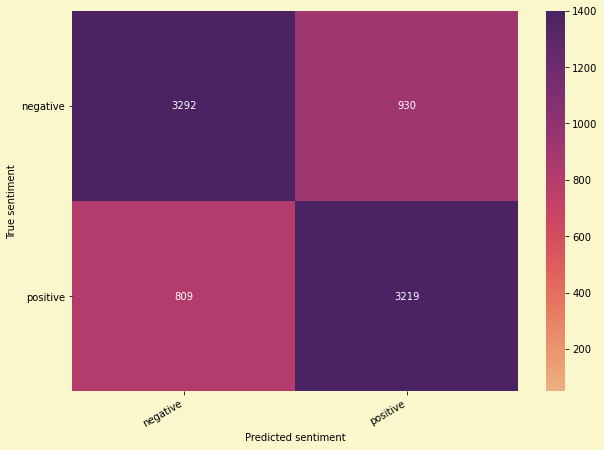

In [40]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="flare",linecolor="red",vmin=50,vmax=1400)
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (10, 7),facecolor='#FAF7CC')
cm = confusion_matrix(Y_test, targets_pred)
df_cm = pd.DataFrame(cm, index=['negative','positive'], columns=['negative','positive'])
show_confusion_matrix(df_cm)